# Dynamic gesture detection

# Dataset Preprocessing

## Cropping hands with mediapipe

In [ ]:
!wget http://domedb.perception.cs.cmu.edu/panopticDB/hands/hand_labels.zip

--2025-01-29 07:37:14--  http://domedb.perception.cs.cmu.edu/panopticDB/hands/hand_labels.zip
Resolving domedb.perception.cs.cmu.edu (domedb.perception.cs.cmu.edu)... 128.2.220.8
Connecting to domedb.perception.cs.cmu.edu (domedb.perception.cs.cmu.edu)|128.2.220.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 589711996 (562M) [application/zip]
Saving to: ‘hand_labels.zip’

hand_labels.zip     100%[===================>] 562.39M  9.86MB/s    in 49s     

2025-01-29 07:38:03 (11.6 MB/s) - ‘hand_labels.zip’ saved [589711996/589711996]



In [ ]:
!unzip hand_labels.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: hand_labels/manual_test/ex2_2.flv_000007_l.json  
  inflating: hand_labels/manual_test/Berry_roof_story.flv_000047_r.jpg  
  inflating: hand_labels/manual_test/003757109_01_l.json  
  inflating: hand_labels/manual_test/Berry_sermon_story.flv_000019_l.jpg  
  inflating: hand_labels/manual_test/075338811_01_r.jpg  
  inflating: hand_labels/manual_test/Berry_sermon_story.flv_000069_l.json  
  inflating: hand_labels/manual_test/092033356_04_l.jpg  
  inflating: hand_labels/manual_test/070301896_02_r.jpg  
  inflating: hand_labels/manual_test/ex2_2.flv_000080_r.json  
  inflating: hand_labels/manual_test/ex2_2.flv_000002_r.jpg  
  inflating: hand_labels/manual_test/069318700_02_r.json  
  inflating: hand_labels/manual_test/043285111_01_r.jpg  
  inflating: hand_labels/manual_test/098925624_03_r.jpg  
  inflating: hand_labels/manual_test/041354052_01_l.jpg  
  inflating: hand_labels/manual_test/Berry_sermon_story.flv_000114_r.jso

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 46.2 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
mp_drawing = mp.solutions.drawing_utils

In [ ]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

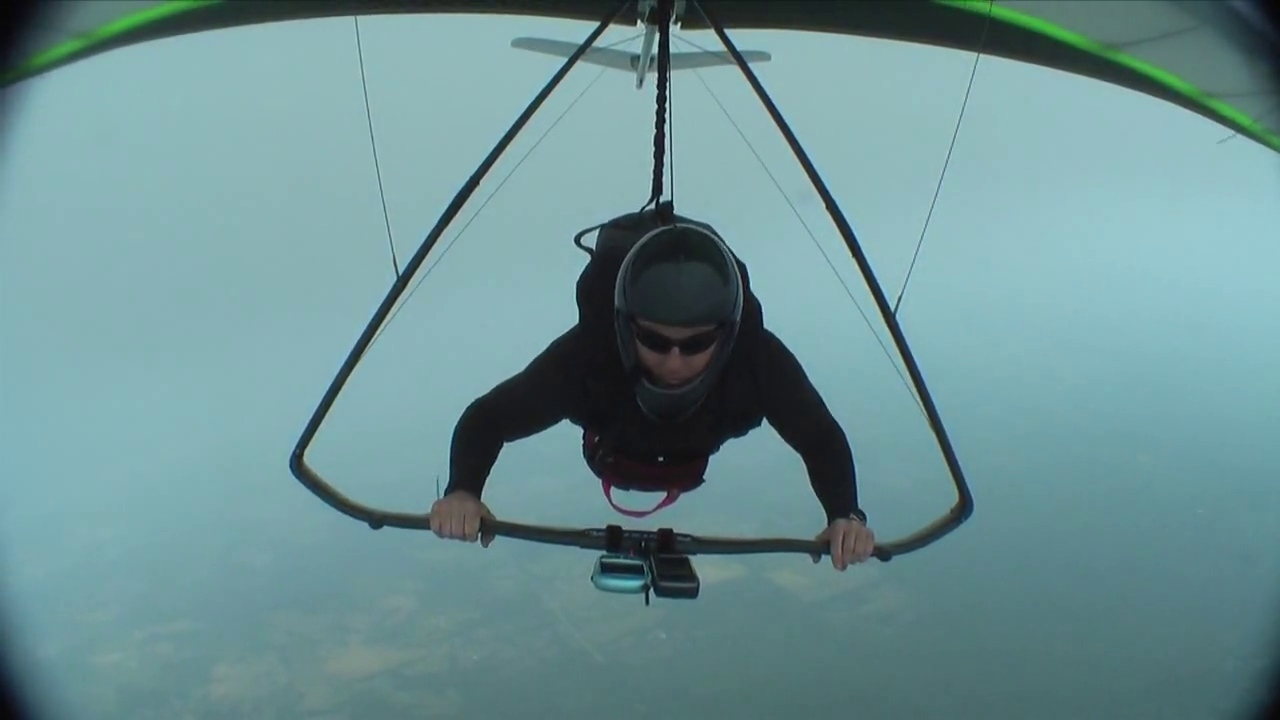

In [ ]:
img = cv2.imread("/content/hand_labels/manual_train/000015774_01_l.jpg")
cv2_imshow(img)

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import cv2

MARGIN = 30  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green


def draw_landmarks_on_image_and_crop(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)
    x_coordinates = []
    y_coordinates = []

    # Loop through the detected hands to visualize and crop.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style())

        # Get the coordinates of all the keypoints
        height, width, _ = annotated_image.shape
        x_coordinates += [int(landmark.x * width) for landmark in hand_landmarks]
        y_coordinates += [int(landmark.y * height) for landmark in hand_landmarks]

    return annotated_image, x_coordinates, y_coordinates

# Example usage:
# annotated_img, hand_crops = draw_landmarks_on_image_and_crop(rgb_image, detection_result)
# Here, `annotated_img` contains the image with landmarks and `hand_crops` is a list of cropped hand regions.


In [ ]:
def crop_hands_region(rgb_image, x_coordinates, y_coordinates):

    height, width, _ = rgb_image.shape

    x_min = max(min(x_coordinates) - MARGIN, 0)
    x_max = min(max(x_coordinates) + MARGIN, width)
    y_min = max(min(y_coordinates) - MARGIN, 0)
    y_max = min(max(y_coordinates) + MARGIN, height)

    return rgb_image[y_min:y_max, x_min:x_max]


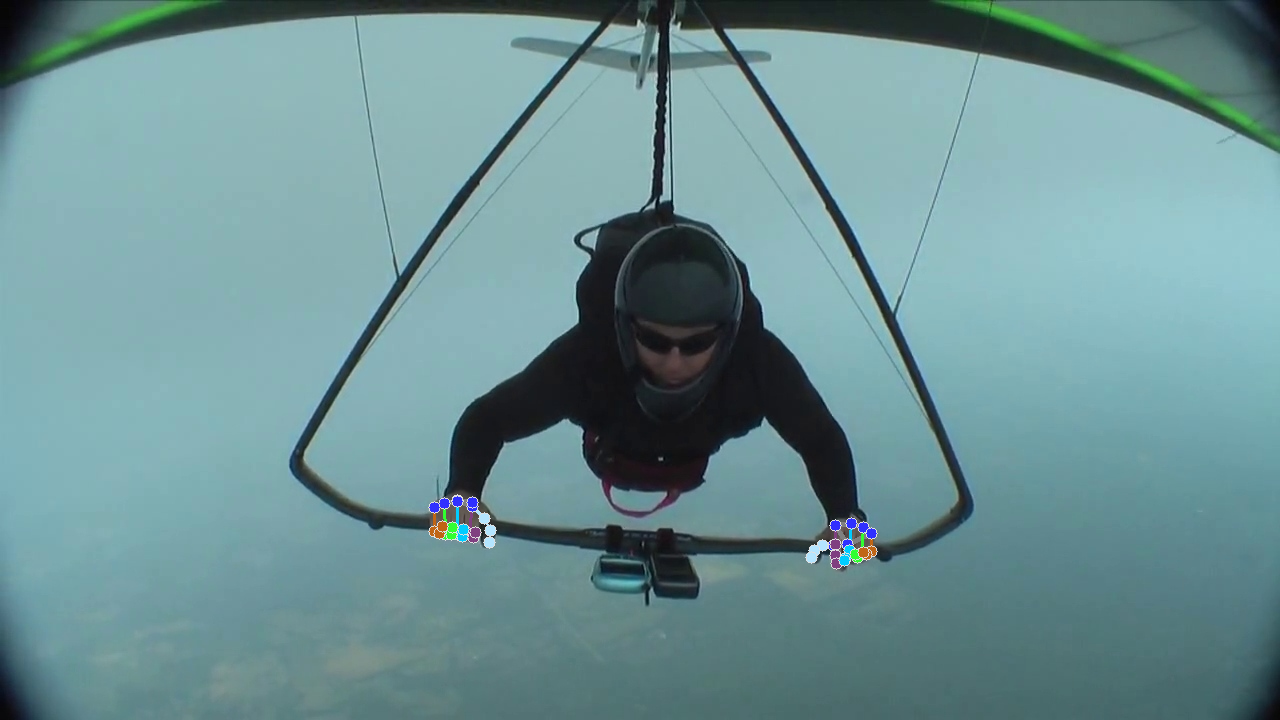

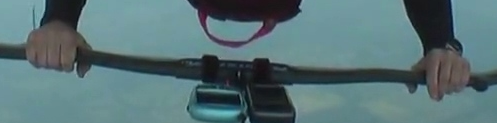

In [ ]:
# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("/content/hand_labels/manual_train/000015774_01_l.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image, x, y = draw_landmarks_on_image_and_crop(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

# Display the cropped images (if needed)
# Assuming 'cropped_images' is a list of images:
cropped_image = crop_hands_region(image.numpy_view(), x, y)
cv2_imshow(cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

In [ ]:
resized_image = cv2.resize(cropped_image, (75, 75))

# Controlla la dimensione dell'immagine risultante
print("Shape:", resized_image.shape)

Shape: (75, 75, 3)


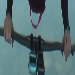

In [ ]:
cv2_imshow(cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

## Feature extraction with InceptionV3


In [ ]:
!pip install keras

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image as image_utils

In [ ]:
pretrained_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(75, 75, 3)
)

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# Input layer
input_layer = Input(shape=(50, 60, 3))

# Convolutional Layer
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)

# Max Pooling Layer
x = MaxPooling2D((2, 2), strides=2)(x)

# Inception Layer
def inception_module(x, filters):
    f1, f2, f3, f4 = filters

    # 1x1 conv
    conv1x1_1 = Conv2D(f1, (1, 1), activation='relu', padding='same')(x)

    # 1x1 conv -> 3x3 conv
    conv1x1_2 = Conv2D(f2, (1, 1), activation='relu', padding='same')(x)
    conv3x3 = Conv2D(f2, (3, 3), activation='relu', padding='same')(conv1x1_2)

    # 1x1 conv -> 5x5 conv
    conv1x1_3 = Conv2D(f3, (1, 1), activation='relu', padding='same')(x)
    conv5x5 = Conv2D(f3, (5, 5), activation='relu', padding='same')(conv1x1_3)

    # 3x3 Max Pool -> 1x1 conv
    pool = MaxPooling2D((3, 3), strides=1, padding='same')(x)
    conv1x1_4 = Conv2D(f4, (1, 1), activation='relu', padding='same')(pool)

    # Concatenation of all branches
    output = Concatenate()([conv1x1_1, conv3x3, conv5x5, conv1x1_4])

    return output

# Apply Inception Module
x = inception_module(x, filters=[32, 64, 64, 32])

# Average Pooling Layer
x = AveragePooling2D((2, 2), strides=2)(x)

# Apply Global Average Pooling to reduce spatial dimensions
x = GlobalAveragePooling2D()(x)  # Output shape will be (192,)

# Optional: Add a Dense layer to match the 2048 output
x = Dense(2048, activation='relu')(x)

# Build model
model = Model(inputs=input_layer, outputs=x)

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 60, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 50, 60, 32)     │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 25, 30, 32)     │              0 │ conv2d_94[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 25, 30, 64)     │          2,112 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 25, 30, 64)     │          2,112 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 25, 30, 32)     │              0 │ max_pooling2d_4[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 25, 30, 32)     │          1,056 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 25, 30, 64)     │         36,928 │ conv2d_96[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 25, 30, 64)     │        102,464 │ conv2d_98[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 25, 30, 32)     │          1,056 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 25, 30, 192)    │              0 │ conv2d_95[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_97[0][0],       │
│                           │                        │                │ conv2d_99[0][0],       │
│                           │                        │                │ conv2d_100[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_9       │ (None, 12, 15, 192)    │              0 │ concatenate_2[0][0]    │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 192)            │              0 │ average_pooling2d_9[0… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2048)           │        395,264 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 541,888 (2.07 MB)

 Trainable params: 541,888 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

## LSTM for classification

In [1]:
!pip install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Definisci il modello LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Dense layer con ReLU
        self.fc1 = nn.Linear(hidden_size, 512)
        self.relu = nn.ReLU()

        # Dense layer finale per la classificazione con Softmax
        self.fc2 = nn.Linear(512, num_classes)

        # Softmax (opzionale nella definizione del modello)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Passa attraverso l'LSTM
        lstm_out, (hn, cn) = self.lstm(x)

        # Prendi l'output finale dell'LSTM (l'ultimo stato hidden)
        lstm_out = hn[-1]  # Usa l'ultimo hidden state dell'LSTM

        # Passa attraverso il primo layer denso con ReLU
        x = self.fc1(lstm_out)
        x = self.relu(x)

        # Passa attraverso il secondo layer denso con Softmax
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Parametri
input_size = 2048  # Dimensione dell'input (2048)
hidden_size = 128  # Numero di unità nel layer LSTM (puoi cambiarlo a seconda delle necessità)
num_classes = 6  # Numero di categorie (classi)

# Instanzia il modello
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()  # Funzione di perdita per classificazione
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Stampa il modello
print(model)

LSTMModel(
  (lstm): LSTM(2048, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
# Inizia il ciclo di addestramento
# Supponiamo che tu abbia un DataLoader con i tuoi dati
# train_loader = ...

# Esegui un ciclo di addestramento
# for epoch in range(num_epochs):
#     for inputs, labels in train_loader:
#         # Aggiungi una dimensione per l'input (batch_size, seq_len, input_size)
#         inputs = inputs.unsqueeze(1)  # Se l'input è 2048x1, aggiungi una dimensione per la sequenza (1)

#         # Zero i gradienti
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         # Calcola la perdita
#         loss = criterion(outputs, labels)

#         # Backward pass
#         loss.backward()

#         # Ottimizza
#         optimizer.step()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")